In [ ]:
import json
import sys
import math
import tensorflow as tf
from pgd_attack import LinfPGDAttack

from tensorflow.examples.tutorials.mnist import input_data

from model import Model

with open('config.json') as config_file:
    config = json.load(config_file)

model_file = tf.train.latest_checkpoint(config['model_dir'])
if model_file is None:
    print('No model found')
sys.exit()

model = Model()
attack = LinfPGDAttack(model,
                        config['epsilon'],
                        config['k'],
                        config['a'],
                        config['random_start'],
                        config['loss_func'])
saver = tf.train.Saver()

mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

with tf.Session() as sess:
    # Restore the checkpoint
    saver.restore(sess, model_file)

    # Iterate over the samples batch-by-batch
    num_eval_examples = config['num_eval_examples']
    eval_batch_size = config['eval_batch_size']
    num_batches = int(math.ceil(num_eval_examples / eval_batch_size))

    x_adv = [] # adv accumulator

    print('Iterating over {} batches'.format(num_batches))

    for ibatch in range(num_batches):
        bstart = ibatch * eval_batch_size
        bend = min(bstart + eval_batch_size, num_eval_examples)
        print('batch size: {}'.format(bend - bstart))

        x_batch = mnist.test.images[bstart:bend, :]
        y_batch = mnist.test.labels[bstart:bend]

        x_batch_adv = attack.perturb(x_batch, y_batch, sess)

        x_adv.append(x_batch_adv)

print('Storing examples')
path = config['store_adv_path']
x_adv = np.concatenate(x_adv, axis=0)
np.save(path, x_adv)
print('Examples stored in {}'.format(path))

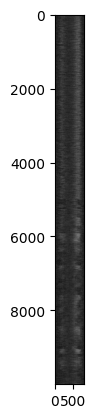

In [7]:
import numpy as np
import matplotlib.pyplot as plt

image = np.load("fgsm_k.npy")

plt.imshow(image, cmap='gray')  # Change cmap if needed
plt.show()
plt.imsave("output_image.png", image, cmap="gray")

In [4]:
from PIL import Image
import numpy as np

# Load the original image (784x1)
original_image = Image.open("your_image.png")

# Convert the image to a numpy array
image_data = np.array(original_image)

# Reshape the data to 28x28 (from 784x1)
reshaped_image = image_data.reshape((28, 28, 4))

# If needed, convert the data to uint8 (for image saving)
reshaped_image = reshaped_image.astype(np.uint8)

# Save the reshaped image as a new PNG
Image.fromarray(reshaped_image).save("reshaped_image.png")

In [5]:
import numpy as np
import gzip

# Function to load MNIST images
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')  # Magic number (ignore)
        num_images = int.from_bytes(f.read(4), 'big')  # Number of images
        rows = int.from_bytes(f.read(4), 'big')  # Image height
        cols = int.from_bytes(f.read(4), 'big')  # Image width
        
        # Read the pixel data and reshape into (num_images, 28, 28)
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
        
    return images

# Load the test images
mnist_images = load_mnist_images("MNIST_data/t10k-images-idx3-ubyte.gz")

# Check shape
print(mnist_images.shape)  # Expected output: (10000, 28, 28)

(10000, 28, 28)


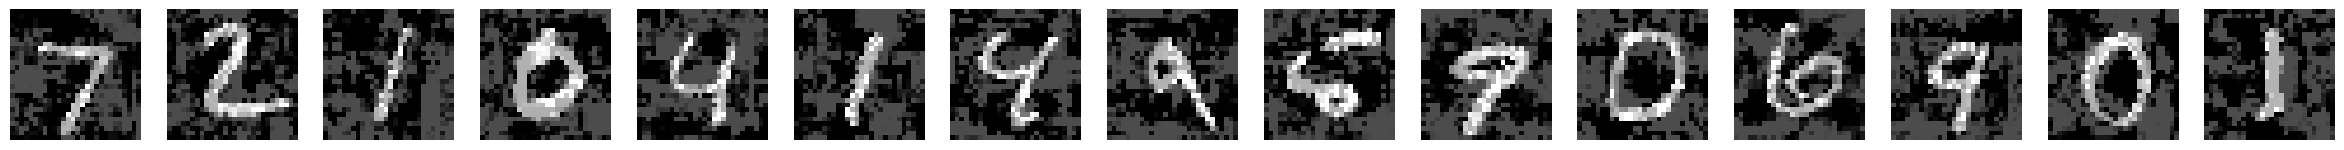

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Generate dummy data (Replace this with your actual ndarray)
#images = np.random.rand(10000, 784)  # Example dataset

# Reshape the images
images_reshaped = image.reshape(10000, 28, 28)

# Function to display images
def display_images(images, num_images=10, images_per_row=5):
    rows = (num_images + images_per_row - 1) // images_per_row  # Calculate number of rows needed
    
    plt.figure(figsize=(images_per_row * 2, rows * 2))  # Adjust figure size
    for i in range(num_images):
        plt.subplot(rows, images_per_row, i + 1)
        plt.imshow(images[i], cmap='gray')  # Display as grayscale
        plt.axis('off')  # Hide axis
    plt.show()

# Display first 15 images in 5 images per row
display_images(images_reshaped, num_images=15, images_per_row=15)

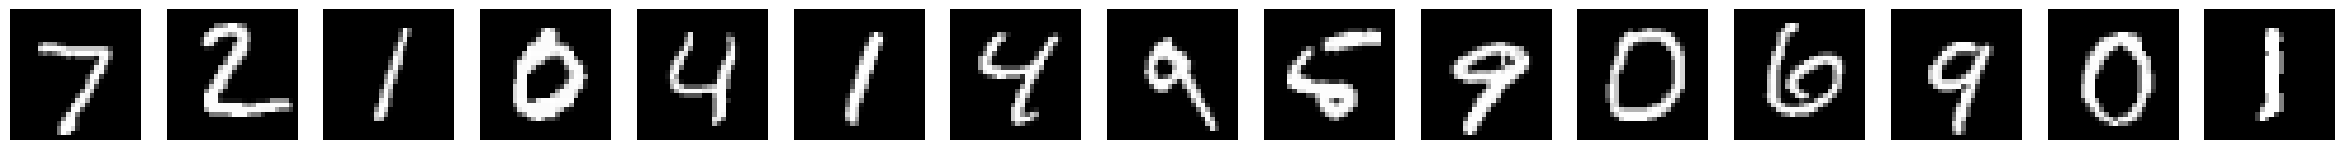

In [11]:
display_images(mnist_images, num_images=15, images_per_row=15)

In [12]:
import numpy as np

# Assuming ndarray1 and ndarray2 are of shape (10000, 28, 28)
def measure_perturbation(original, perturbed):
    # Compute Mean Squared Error (MSE) per image
    mse_per_image = np.mean((original - perturbed) ** 2, axis=(1, 2))
    
    # Compute average MSE across all images
    avg_mse = np.mean(mse_per_image)
    
    return avg_mse

# Example usage
#images_reshaped = np.random.rand(10000, 28, 28)  # Simulated perturbed data
#mnist_images = np.random.rand(10000, 28, 28)  # Simulated original data

perturbation_score = measure_perturbation(images_reshaped, mnist_images)
print(f"Average perturbation (MSE): {perturbation_score}")

Average perturbation (MSE): 7361.417928914311
